<a href="https://colab.research.google.com/github/mahesh-babu-chittem/Machine-Learning-MaheshBabuChittem/blob/main/REAL_ESTATE_PRICE_FORECASTING_WITH_EXPLAINABLE_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Estate Forecasting with Explainable ML

**Checklist implemented:**
- Full lifecycle: Data → Preprocessing → Model → Evaluation → Deployment  
- In-depth EDA: distributions, outliers, correlations, missingness, feature-target trends  
- Feature engineering (derived features + ordinal handling)  
- Baseline & advanced models (RF, GBM) + Optuna tuning  
- Proper regression metrics + visualizations (RMSE, MAE, MAPE, R², residuals)  
- Error analysis + interpretability (feature importance, permutation, SHAP, LIME fallback)  
- Save pipeline artifact for Flask UI: `house_price_model_rf_pipeline.joblib`

> **Important:** This notebook preserves your existing variable names (e.g., `df_selected`) so your Flask UI continues to work.


## 📌 Cell 2 — Import Libraries & Environment Check

This cell imports all the essential Python libraries required for data analysis, visualization, preprocessing, and machine learning.

### 🔹 What this cell does
- Loads core libraries: **numpy, pandas, matplotlib, seaborn**
- Loads ML components from **scikit-learn**, including:
  - Preprocessing tools (imputers, scalers, encoders)
  - Model selection utilities (train/test split, CV, hyperparameter search)
  - Regression models (Linear Regression, Ridge, Random Forest, Gradient Boosting)
  - Evaluation metrics (RMSE, MAE, R²)
- Imports `joblib` for saving trained pipelines
- Prints environment details (Python, OS, pandas, sklearn versions)

### 🔹 Why this cell is important
- Sets up all dependencies for the ML pipeline  
- Ensures compatibility and reproducibility of the entire notebook  
- Helps verify that the correct library versions are installed before execution


In [ ]:
# Cell 2: imports and environment info
import sys, platform, warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib
from datetime import datetime

# sklearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__, "scikit-learn:", sklearn.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
pandas: 2.2.2 scikit-learn: 1.6.1


## 📌 Cell 3 — Load Dataset & Create `df_selected`

### 🔹 What this cell does
- Loads the **Kaggle House Prices dataset** (`train.csv`) from the working directory.
- Validates that the file exists; otherwise raises an error.
- Reads the dataset into a DataFrame and prints:
  - Full dataset shape  
  - First five rows
- Defines a `column_mapping` dictionary to rename raw Kaggle column names into cleaner, user-friendly names.
- Checks if any required columns are missing and raises an error if so.
- Creates a filtered dataframe **`df_selected`** containing only the 10 relevant columns, renamed properly.

### 🔹 Why this cell is important
- Reduces the original dataset (81 columns) to only the features needed for EDA and modeling.
- Ensures consistent column naming across:
  - EDA  
  - Preprocessing  
  - Final ML pipeline  
  - Deployment (Flask UI)
- Prevents runtime errors by verifying the presence of required columns before proceeding.


In [ ]:
# Cell 3: Load dataset from local train.csv and create df_selected
import os

# CHANGE HERE if the file is in another location:
csv_path = "train.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found in working directory. Upload it or change csv_path.")

df = pd.read_csv(csv_path)
print("Full dataset shape:", df.shape)
display(df.head())

# Map columns to UI variable names (ensure these columns exist in train.csv)
column_mapping = {
    "GrLivArea": "SquareFeet",
    "BedroomAbvGr": "Bedrooms",
    "FullBath": "Bathrooms",
    "YearBuilt": "YearBuilt",
    "LotArea": "LotSize",
    "Neighborhood": "Neighborhood",
    "HouseStyle": "HouseStyle",
    "Exterior1st": "Exterior",
    "KitchenQual": "KitchenQuality",
    "SalePrice": "SalePrice"
}

missing_keys = [k for k in column_mapping.keys() if k not in df.columns]
if missing_keys:
    raise KeyError(f"The following expected columns are missing in train.csv: {missing_keys}")

df_selected = df[list(column_mapping.keys())].rename(columns=column_mapping)
print("df_selected created with columns:", df_selected.columns.tolist())
display(df_selected.head())

Full dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


df_selected created with columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize', 'Neighborhood', 'HouseStyle', 'Exterior', 'KitchenQuality', 'SalePrice']


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,LotSize,Neighborhood,HouseStyle,Exterior,KitchenQuality,SalePrice
0,1710,3,2,2003,8450,CollgCr,2Story,VinylSd,Gd,208500
1,1262,3,2,1976,9600,Veenker,1Story,MetalSd,TA,181500
2,1786,3,2,2001,11250,CollgCr,2Story,VinylSd,Gd,223500
3,1717,3,1,1915,9550,Crawfor,2Story,Wd Sdng,Gd,140000
4,2198,4,2,2000,14260,NoRidge,2Story,VinylSd,Gd,250000


## Problem statement (≤150 words)
Predict the continuous `SalePrice` using available house features. Primary objective: minimize RMSE on held-out data. Secondary objectives: MAE, MAPE, and R². Provide interpretability (SHAP/permutation) and save a pipeline artifact (`house_price_model_rf_pipeline.joblib`) for the Flask UI. All preprocessing and model logic will be contained in the saved pipeline.


## 📌 Cell — EDA-1: Structure, Summary Stats & Missing Values

### 🔹 What this cell does
- Shows dataset **shape**, **data types**, and **summary statistics**.
- Computes **missing values** for all columns.
- Plots a **missing-value heatmap**.

### 🔹 What it reveals
- **No missing values** in any feature.
- Numeric features show varied ranges (e.g., LotSize highly spread).

### 🔹 Why it matters
- Confirms dataset **cleanliness**.
- Helps decide preprocessing steps (imputation, encoding, scaling).
- Provides the base understanding needed for further EDA.


Shape: (1460, 10)

Data types:


,0
SquareFeet,int64
Bedrooms,int64
Bathrooms,int64
YearBuilt,int64
LotSize,int64
Neighborhood,object
HouseStyle,object
Exterior,object
KitchenQuality,object
SalePrice,int64



Summary statistics:


,count,mean,std,min,25%,50%,75%,max
SquareFeet,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
Bedrooms,1460.0,2.866438,0.815778,0.0,2.0,3.0,3.00,8.0
Bathrooms,1460.0,1.565068,0.550916,0.0,1.0,2.0,2.00,3.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.0,1973.0,2000.00,2010.0
LotSize,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0



Missing values per column:


,0
SquareFeet,0
Bedrooms,0
Bathrooms,0
YearBuilt,0
LotSize,0
Neighborhood,0
HouseStyle,0
Exterior,0
KitchenQuality,0
SalePrice,0


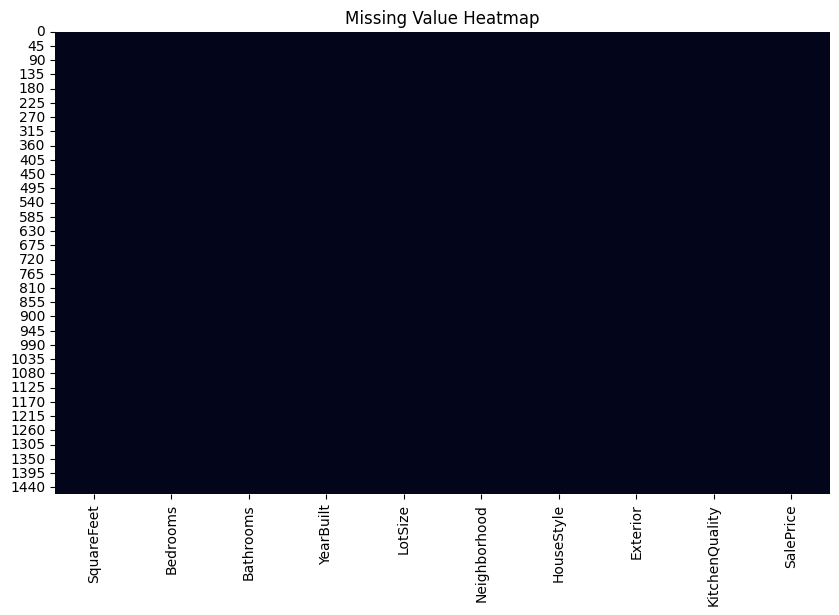

In [ ]:
# EDA-1: Structure, types, missingness, summary statistics
print("Shape:", df_selected.shape)

print("\nData types:")
display(df_selected.dtypes)

print("\nSummary statistics:")
display(df_selected.describe().T)

print("\nMissing values per column:")
missing = df_selected.isnull().sum().sort_values(ascending=False)
display(missing)

# Missingness heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_selected.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


## 📌 Cell — EDA-2: Target Variable (SalePrice) Analysis

### 🔹 What this cell does
- Plots **histogram + KDE** and **boxplot** for `SalePrice`.
- Computes **skewness** and **kurtosis**.
- Visualizes the **log-transformed** price distribution.

### 🔹 What it reveals
- `SalePrice` is **right-skewed** (skew ≈ 1.88) with **heavy tails** (kurtosis ≈ 6.53).
- Presence of **high-value outliers**.
- Log-transform produces a **more symmetric distribution**.

### 🔹 Why it matters
- Skewed target harms linear models → log-transform helps.
- Confirms need for robust models (Random Forest, Gradient Boosting).
- Provides foundational insight into price variability.


Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


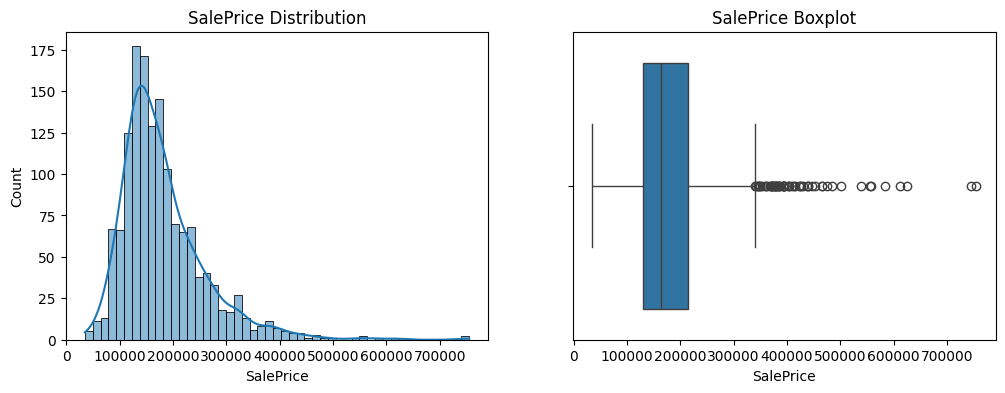

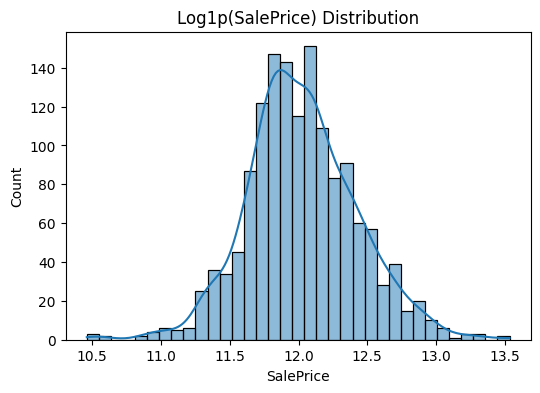

In [ ]:
# EDA-2: Target variable (SalePrice) analysis
target = 'SalePrice'

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_selected[target], kde=True, ax=axes[0])
axes[0].set_title("SalePrice Distribution")

sns.boxplot(x=df_selected[target], ax=axes[1])
axes[1].set_title("SalePrice Boxplot")

print("Skewness:", df_selected[target].skew())
print("Kurtosis:", df_selected[target].kurt())

plt.show()

# Log transform distribution
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df_selected[target]), kde=True)
plt.title("Log1p(SalePrice) Distribution")
plt.show()


## 📌 Cell — EDA-3: Distribution Analysis of Numeric Features

### 🔹 What this cell does
- Identifies all numeric columns except the target (`SalePrice`).
- For each numeric feature, it generates:
  - A **histogram + KDE** to show distribution shape.
  - A **boxplot** to detect outliers.

### 🔹 What it reveals
- Shows which features are **normally distributed**, **skewed**, or have **long tails**.
- Detects **outliers** in features like `LotSize` and `SquareFeet`.
- Helps understand spread, central tendency, and unusual values.

### 🔹 Why it matters
- Distribution shapes guide transformations (log, scaling).
- Outlier detection helps choose robust models (e.g., tree-based).
- Essential step before feature engineering and model training.


Numeric columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize']


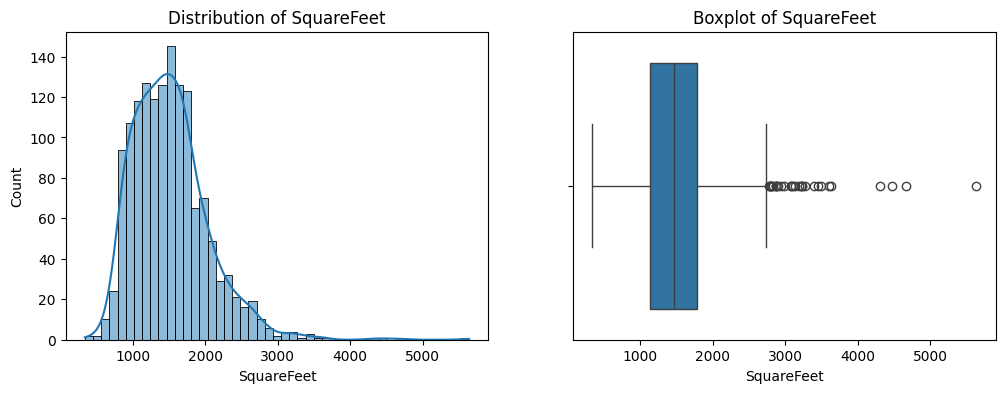

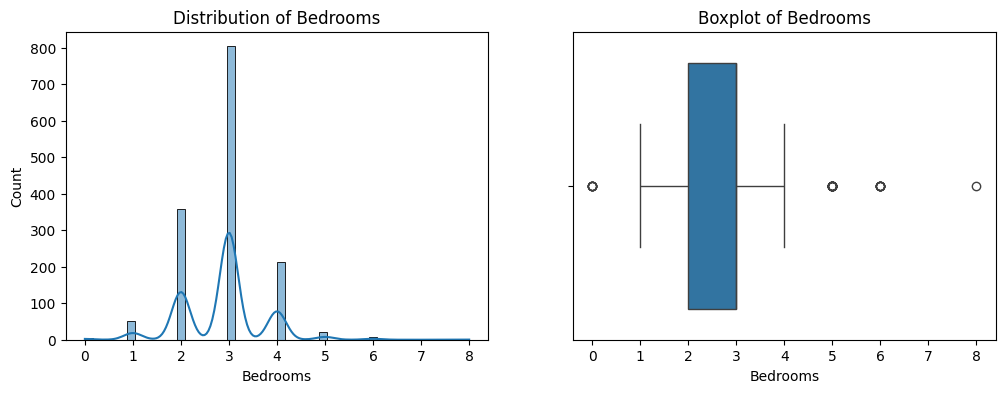

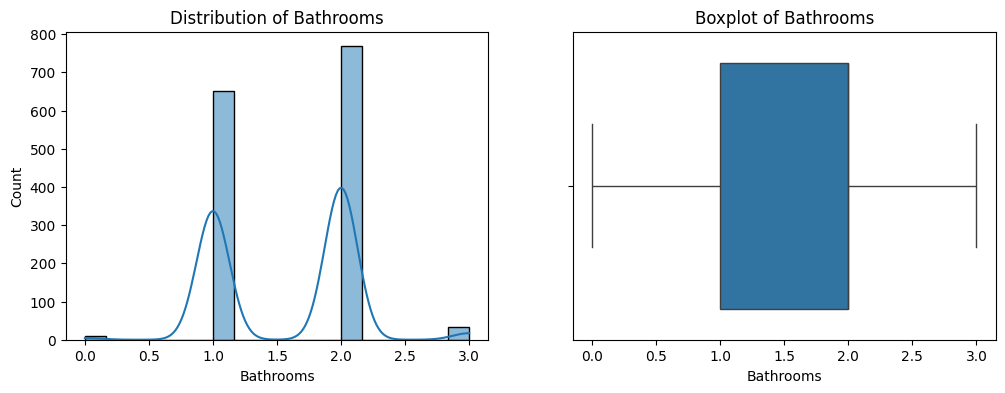

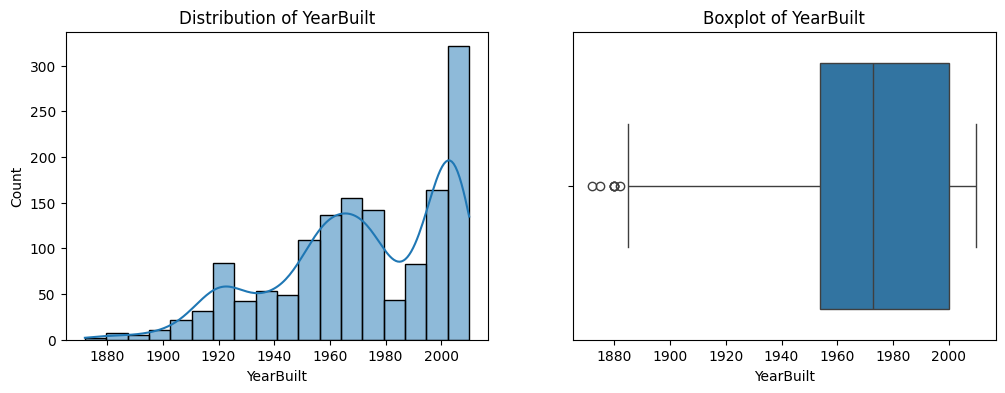

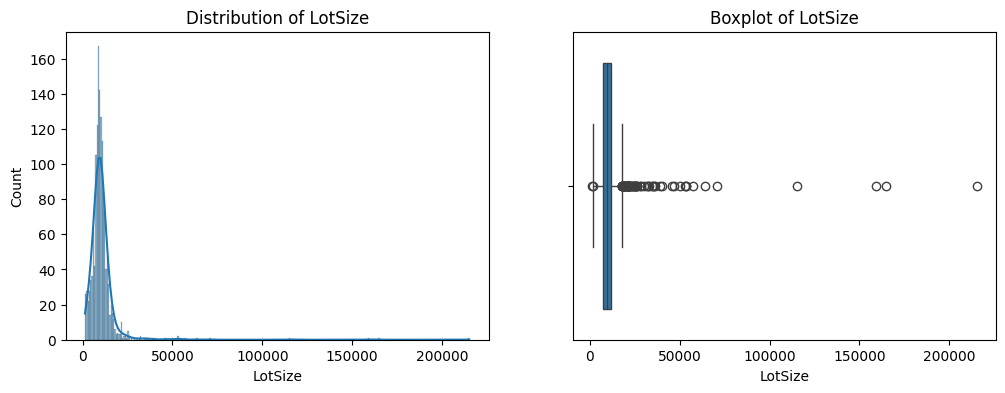

In [ ]:
# EDA-3: Numeric features distribution, boxplots, and KDEs
num_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('SalePrice')

print("Numeric columns:", num_cols)

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df_selected[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')

    sns.boxplot(x=df_selected[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')

    plt.show()


## 📌 Cell — EDA-5: Correlation Analysis (Numeric Features Only)

### 🔹 What this cell does
- Selects only numeric columns from the dataset.
- Computes a **correlation matrix** and visualizes it using a heatmap.
- Extracts the **top correlations with the target variable** (`SalePrice`).

### 🔹 What it reveals
- Identifies strong positive relationships:
  - `SquareFeet`, `Bathrooms`, and `YearBuilt` show the highest correlation with `SalePrice`.
- Highlights weak or negligible correlations (e.g., `Bedrooms`, `LotSize`).
- Shows multicollinearity among numeric predictors.

### 🔹 Why it matters
- Correlation helps identify **important predictive features**.
- Guides **feature selection** and model design.
- Helps detect redundant features that may inflate variance or reduce model stability.


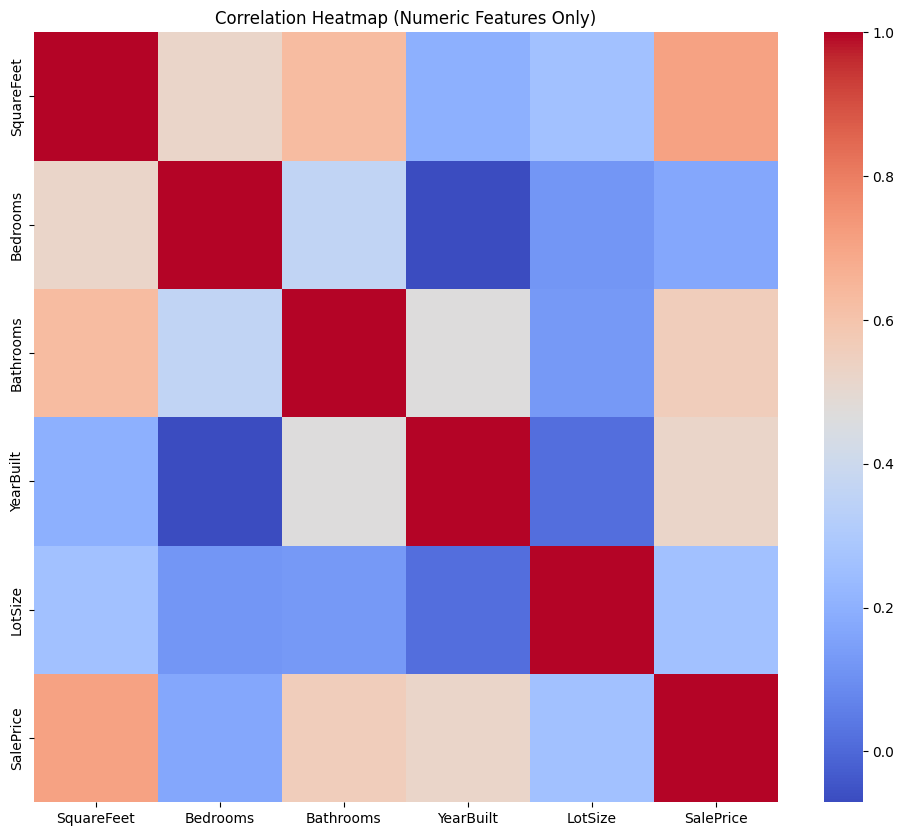

Top correlations with SalePrice:


,SalePrice
SalePrice,1.000000
SquareFeet,0.708624
Bathrooms,0.560664
YearBuilt,0.522897
LotSize,0.263843
Bedrooms,0.168213


In [ ]:
# EDA-5: Correlation Heatmap (NUMERIC ONLY — FIXED)

# select only numeric columns
numeric_df = df_selected.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# top correlations with SalePrice
corr_target = corr['SalePrice'].abs().sort_values(ascending=False)
print("Top correlations with SalePrice:")
display(corr_target)


## 📌 Cell — EDA-6: Pairplots for Top Numeric Predictors

### 🔹 What this cell does
- Selects only the **numeric columns**.
- Computes correlations with `SalePrice` and extracts the **top 5 numeric predictors**.
- Generates a **pairplot** comparing these features with each other and with `SalePrice`.

### 🔹 What it reveals
- Shows how strongly each top feature relates to the target through:
  - Scatter patterns  
  - Linear or nonlinear trends  
  - Distribution overlaps
- Confirms that `SquareFeet`, `Bathrooms`, and `YearBuilt` show clearer upward trends.

### 🔹 Why it matters
- Visualizes **multi-feature interactions**, not just individual effects.
- Helps detect:
  - Nonlinear relationships  
  - Clusters  
  - Heteroscedasticity  
- Supports better **feature understanding** before modeling.


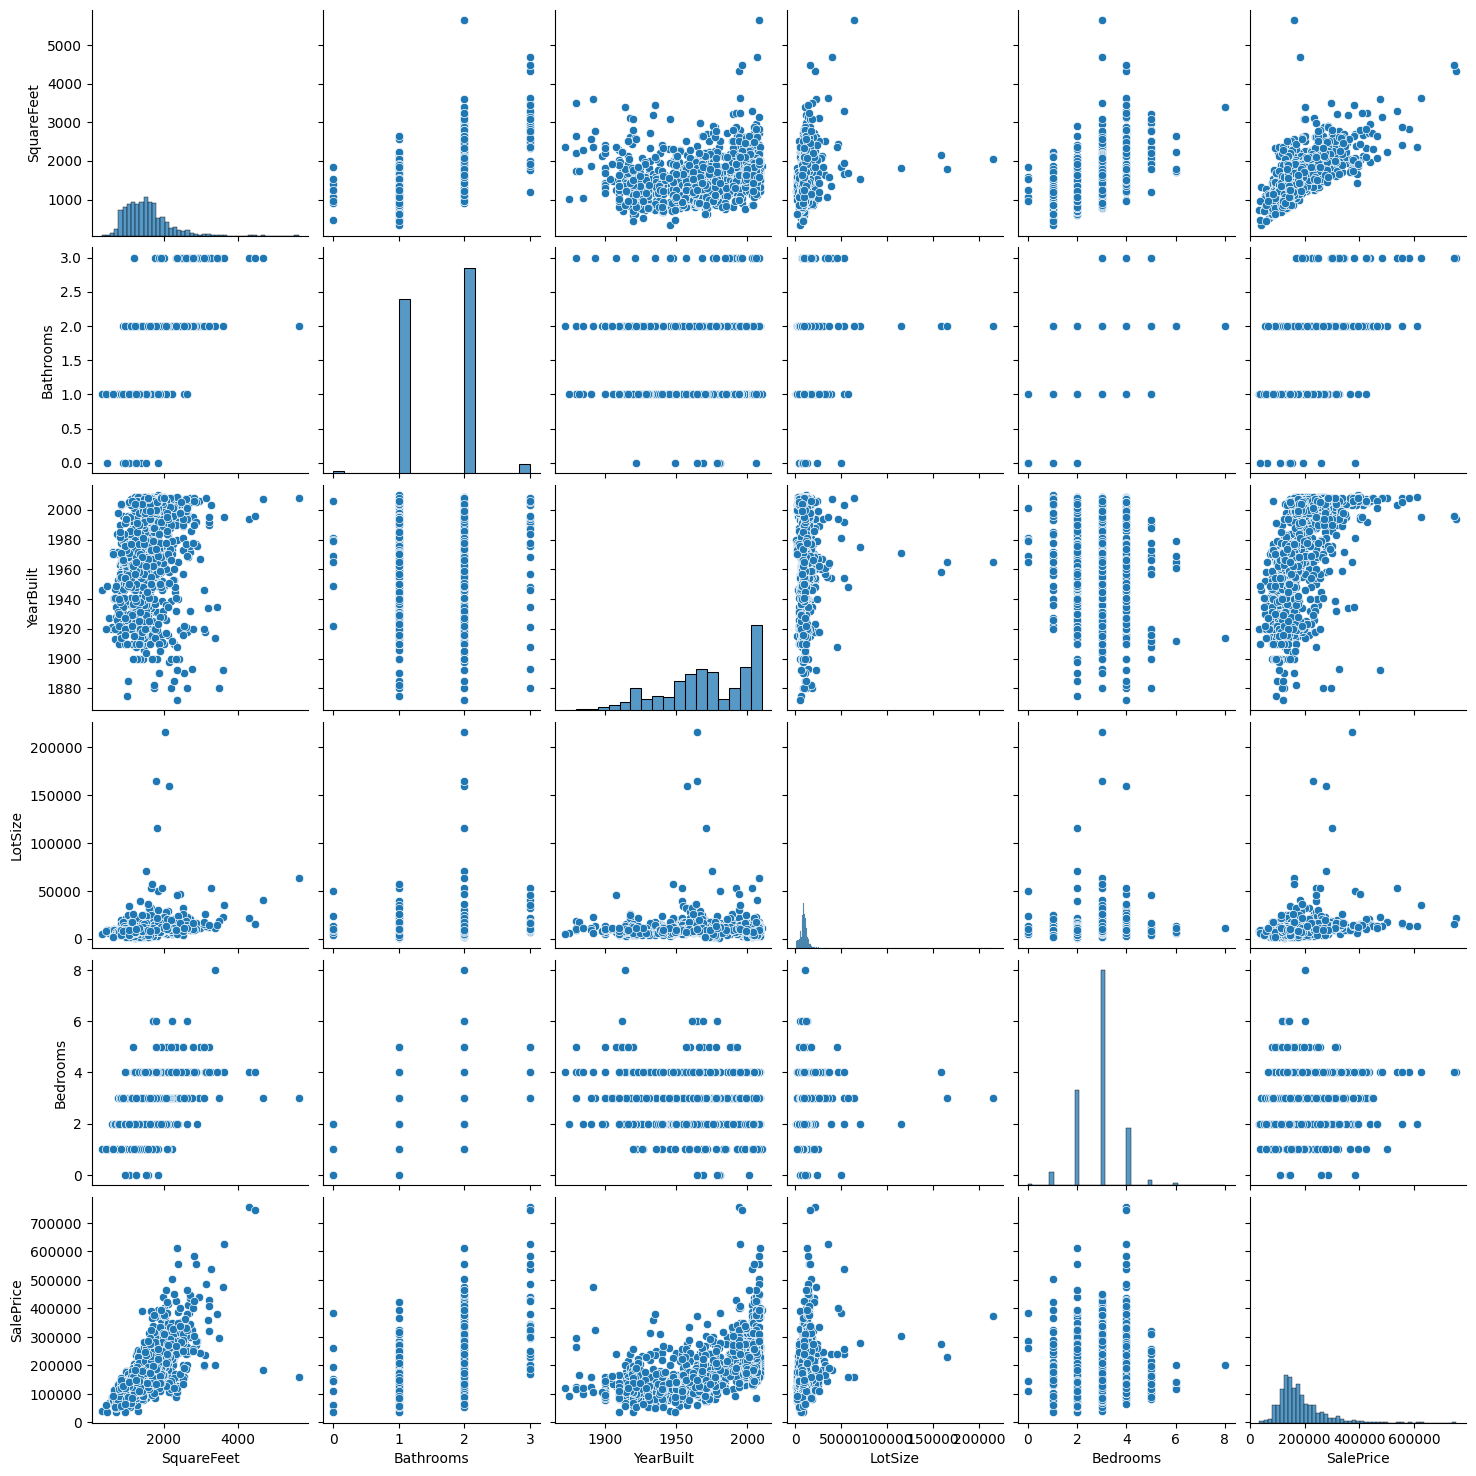

In [ ]:
# EDA-6: Pairplots (top numeric features vs SalePrice) FIXED

# use numeric columns only
numeric_df = df_selected.select_dtypes(include=[np.number])

corr_target = numeric_df.corr()['SalePrice'].abs().sort_values(ascending=False)
top_numeric = corr_target.index[1:6].tolist()  # exclude 'SalePrice'

sns.pairplot(df_selected[top_numeric + ['SalePrice']])
plt.show()


## 📌 Cell — EDA-7: Feature–Target Scatter Plots with Regression Lines

### 🔹 What this cell does
- Iterates through each of the **top numeric predictors** (identified earlier).
- Plots a **scatter plot** of each feature against `SalePrice`.
- Adds a **regression line** using `sns.regplot()` to show the direction and strength of the relationship.

### 🔹 What it reveals
- **SquareFeet** → Strong positive linear trend; larger homes tend to have higher prices.  
- **Bathrooms** → Clear upward trend; more bathrooms correlate with higher sale price.  
- **YearBuilt** → Newer properties generally sell for more.  
- **LotSize** → Weak but visible positive relationship; large lots do not always mean high prices.  
- **Bedrooms** → Weak linear trend; adding bedrooms alone does not strongly affect price.

### 🔹 Why it matters
- Makes feature–target relationships visually interpretable.
- Highlights which predictors will contribute **linearly** to price.
- Helps identify:
  - Nonlinear patterns  
  - Clustered behavior  
  - Potential outliers affecting trendlines  

These insights directly guide model selection and feature engineering.


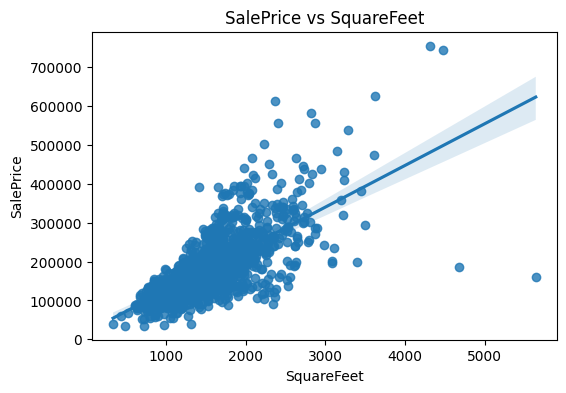

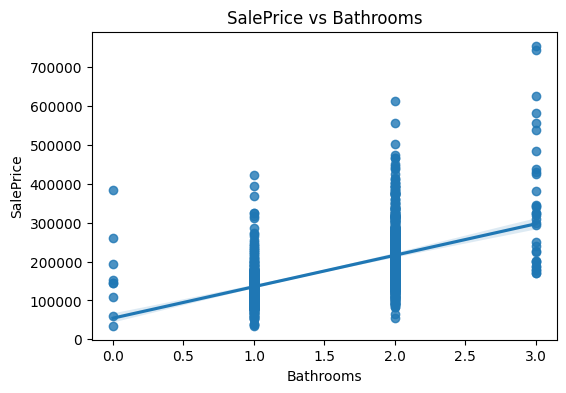

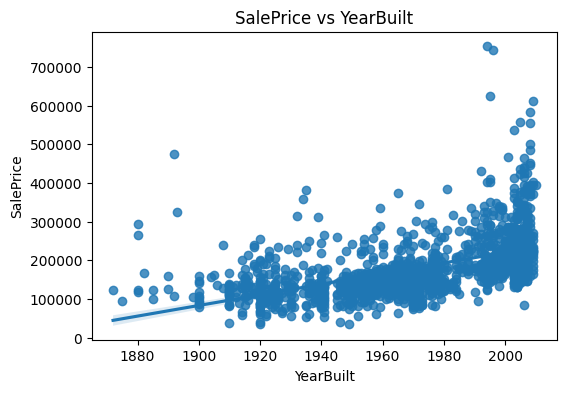

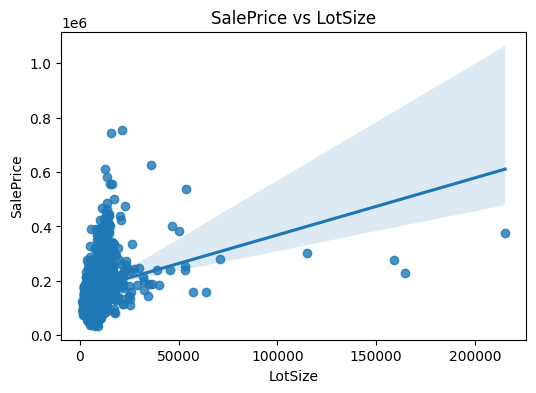

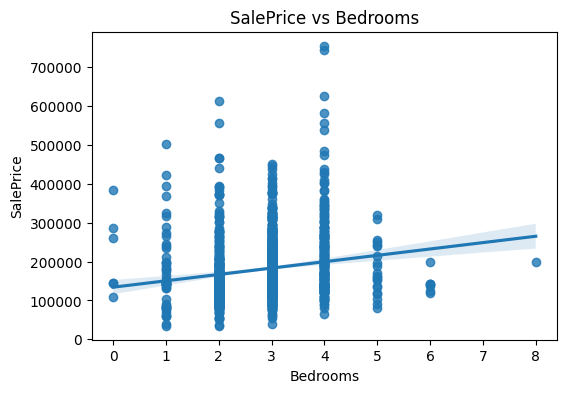

In [ ]:
# EDA-7: Feature-target scatter + regression line
for col in top_numeric:
    plt.figure(figsize=(6,4))
    sns.regplot(x=df_selected[col], y=df_selected['SalePrice'])
    plt.title(f'SalePrice vs {col}')
    plt.show()


## 📌 Cell — EDA-8: Categorical Features vs SalePrice (Boxplots & Violin Plots)

### 🔹 What this cell does
- Identifies all categorical columns in the dataset.
- For each categorical feature:
  - Selects the **top 10 most frequent categories** to avoid overcrowded plots.
  - Creates:
    - A **boxplot** showing median, quartiles, and outliers of `SalePrice` across categories.
    - A **violin plot** showing the **distribution density** of sale prices within each category.

### 🔹 What it reveals
- **Neighborhood** is one of the strongest categorical drivers of price; premium areas show much higher medians.  
- **HouseStyle** and **Exterior** show clear differences in price clusters depending on architectural or finishing type.  
- **KitchenQuality** exhibits a sharp price jump from *TA → Gd → Ex*, confirming it as a major qualitative predictor.

### 🔹 Why it matters
- Categorical variables often encode **location, quality, and design**, which strongly affect price.
- Boxplots help identify:
  - Median price differences  
  - Spread and variability  
  - Outlier-heavy categories  
- Violin plots highlight:
  - Multi-modal behavior  
  - Dense price clusters  
- These insights motivate:
  - **One-Hot Encoding** for general categories  
  - **Ordinal Encoding** for ordered categories such as *KitchenQuality*  
  - Special treatment for categories with skewed value distributions.

This analysis ensures that categorical predictors are encoded appropriately for modeling.


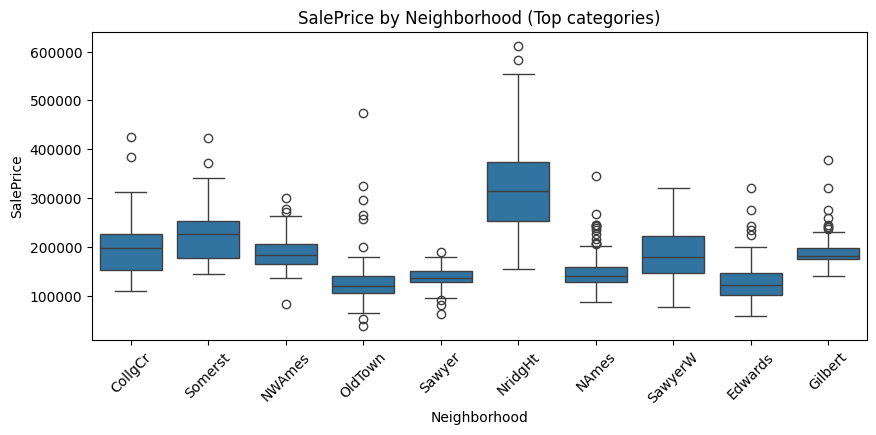

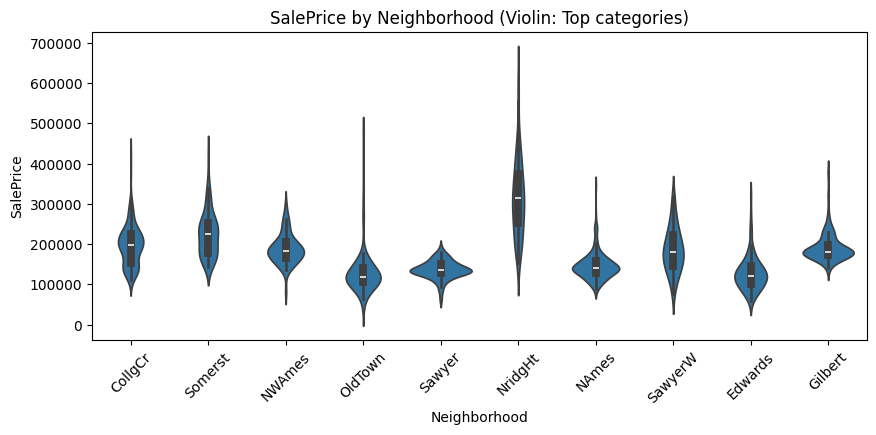

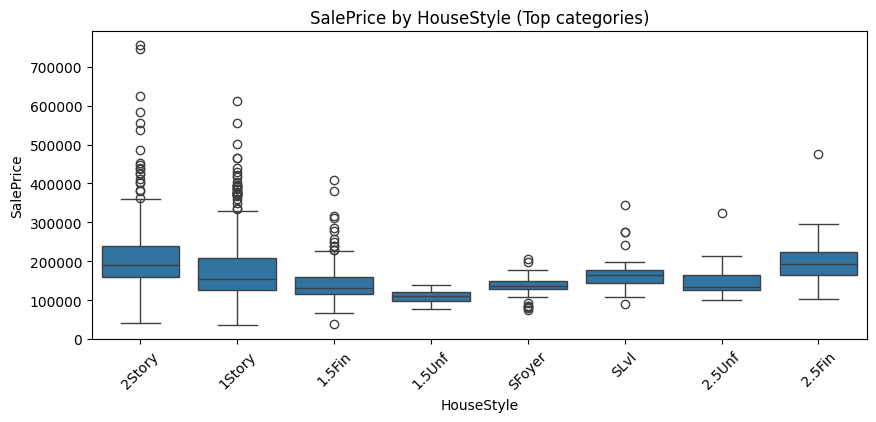

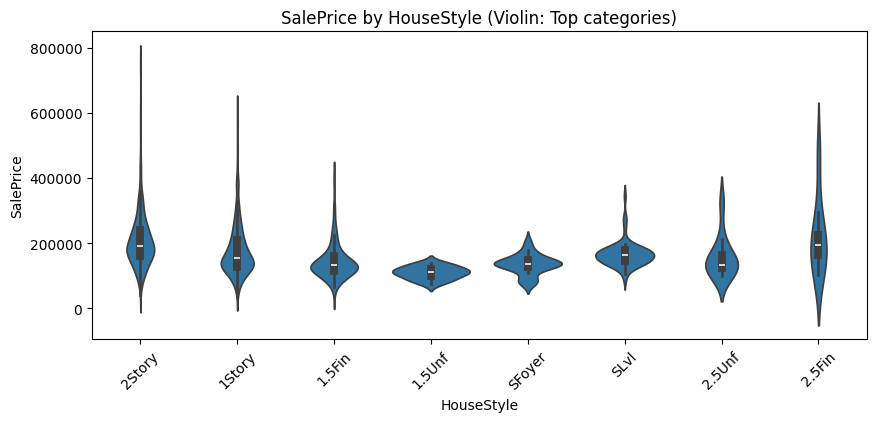

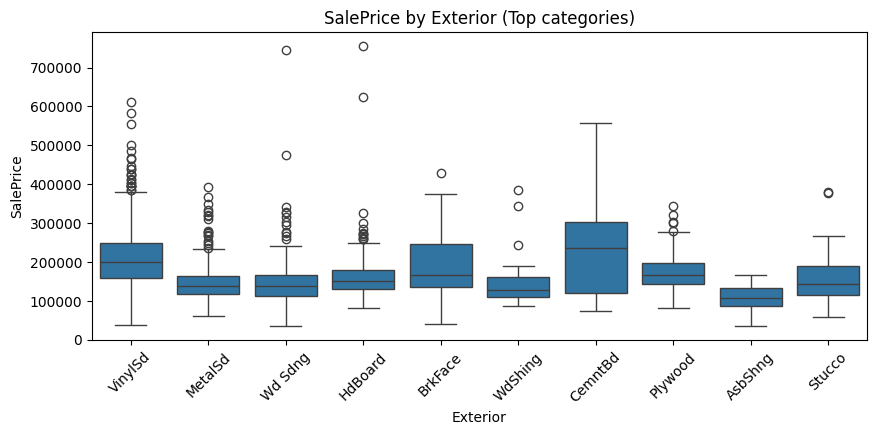

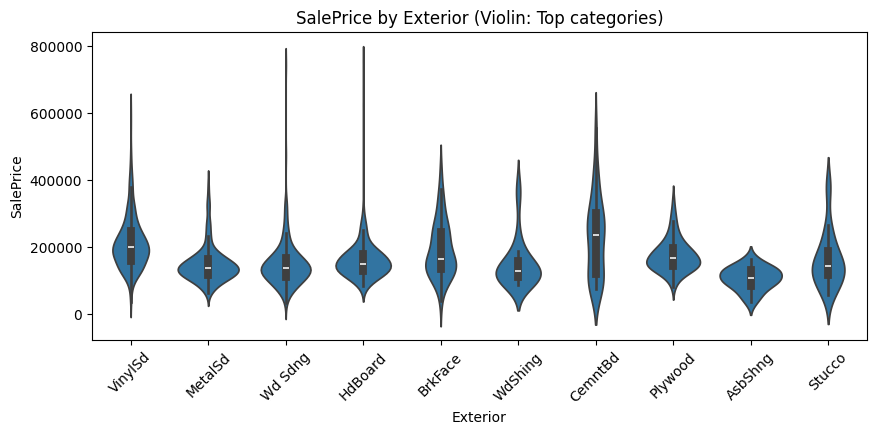

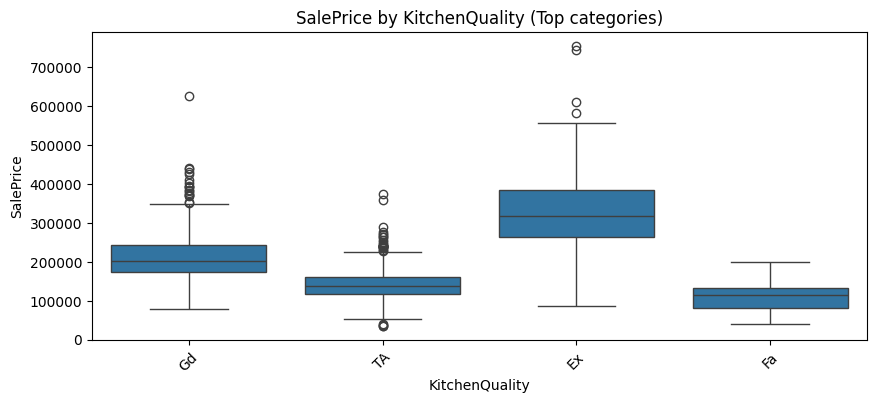

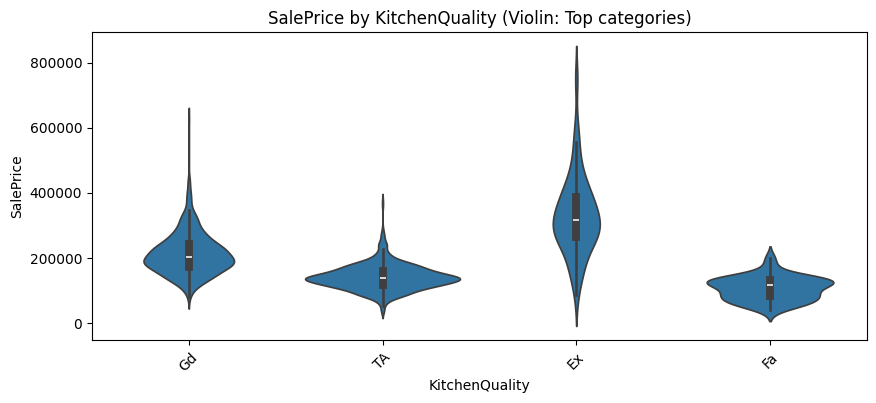

In [ ]:
# EDA-8: Boxplots for categorical features vs SalePrice (FIXED)

# Recompute categorical columns in case kernel restarted
cat_cols = df_selected.select_dtypes(include=['object','category']).columns.tolist()

for col in cat_cols:
    top_levels = df_selected[col].value_counts().head(10).index

    # Boxplot
    plt.figure(figsize=(10,4))
    sns.boxplot(
        x=df_selected[col].where(df_selected[col].isin(top_levels)),
        y=df_selected['SalePrice']
    )
    plt.title(f'SalePrice by {col} (Top categories)')
    plt.xticks(rotation=45)
    plt.show()

    # Violin plot
    plt.figure(figsize=(10,4))
    sns.violinplot(
        x=df_selected[col].where(df_selected[col].isin(top_levels)),
        y=df_selected['SalePrice']
    )
    plt.title(f'SalePrice by {col} (Violin: Top categories)')
    plt.xticks(rotation=45)
    plt.show()

## 📌 Cell — EDA-9: Outlier Analysis (Z-Score & IQR)

### 🔹 What this cell does
- Computes **Z-scores** for all numeric features to identify extreme values.
- Counts how many entries exceed the threshold **|Z| > 3**, which signals statistical outliers.
- Uses **IQR-based boxplots** for top correlated numeric features to visually show:
  - Data spread
  - Extreme high/low values
  - Skewness and tail behavior

### 🔹 What it reveals
- Features like **LotSize**, **SquareFeet**, and **Bedrooms** contain a significant number of outliers.
- **Bathrooms** has almost no extreme values, indicating stable distribution.
- Boxplots show long upper tails, especially for large houses and large plots, confirming dataset skew.

### 🔹 Why it matters
- Outliers impact:
  - Linear models (high sensitivity)
  - Error metrics (RMSE is heavily affected)
- Helps justify:
  - Use of **tree-based models** (outlier-robust)
  - Potential **log transformations** (e.g., LotSize)
  - Avoiding aggressive removal, since outliers represent legitimate high-value homes

This step ensures awareness of irregular values and guides model selection and preprocessing decisions.


Outliers detected using Z-score (>3):


,0
SquareFeet,16
Bedrooms,14
Bathrooms,0
YearBuilt,6
LotSize,13


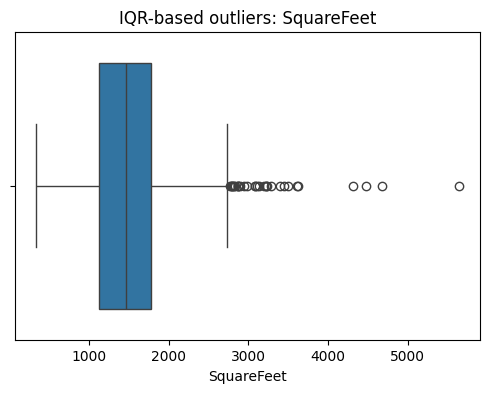

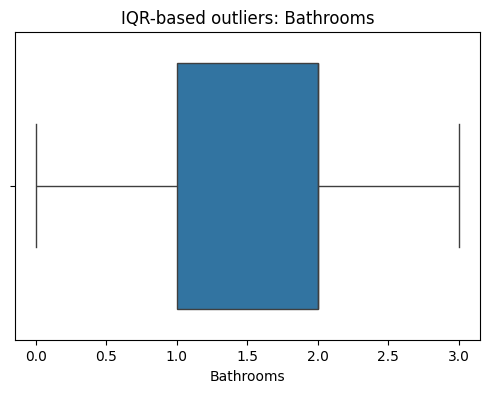

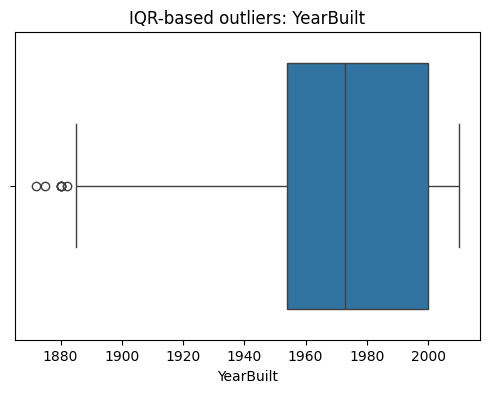

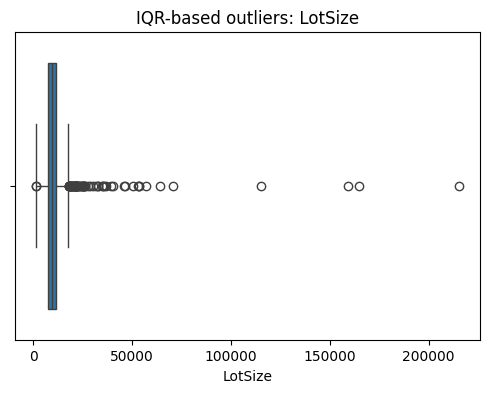

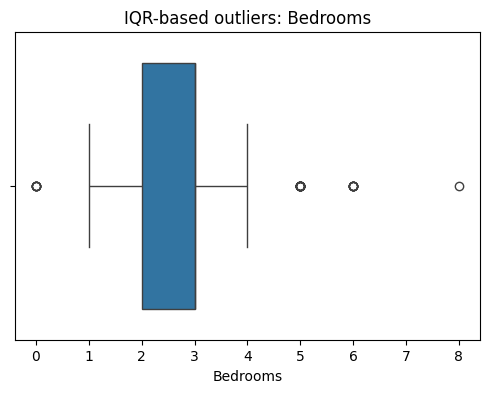

In [ ]:
# EDA-9: Outlier analysis (Z-score)
from scipy import stats

z_df = df_selected[num_cols].apply(lambda x: np.abs(stats.zscore(x)))
outlier_counts_z = (z_df > 3).sum()
print("Outliers detected using Z-score (>3):")
display(outlier_counts_z)

# IQR range visualization for top numeric features
for col in top_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df_selected[col])
    plt.title(f'IQR-based outliers: {col}')
    plt.show()


## 📌 Cell — EDA-10: Variance Inflation Factor (VIF)

### 🔹 What this cell does
- Computes the **Variance Inflation Factor (VIF)** for every numeric feature.
- VIF quantifies how strongly a feature is linearly correlated with other features.
- Creates a table listing each numeric feature along with its VIF score.

### 🔹 What it reveals
- Features such as **SquareFeet**, **Bedrooms**, **Bathrooms**, and **YearBuilt** show **very high VIF values** (above 10).
- This indicates **strong multicollinearity**, meaning the predictors share overlapping information.
- LotSize has a low VIF and is not highly multicollinear.

### 🔹 Why it matters
- High multicollinearity:
  - Makes linear regression coefficients unstable.
  - Increases variance of predictions.
  - Reduces interpretability of coefficient-based models.

- This analysis justifies:
  - Preferring **tree-based models** (RF, GBM), which are not affected by multicollinearity.
  - Using **regularization** techniques (Ridge, Lasso) if linear models are used.
  - Avoiding redundant predictors or combining them during feature engineering.

VIF evaluation ensures the model is aware of correlated predictors and guides appropriate model choice.


In [ ]:
# EDA-10: VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols
vif_data["VIF"] = [variance_inflation_factor(df_selected[num_cols].values, i)
                   for i in range(len(num_cols))]

print("Variance Inflation Factor (VIF):")
display(vif_data.sort_values("VIF", ascending=False))


Variance Inflation Factor (VIF):


,Feature,VIF
0,SquareFeet,19.469373
1,Bedrooms,18.084477
3,YearBuilt,16.761371
2,Bathrooms,15.396408
4,LotSize,2.274477


In [ ]:
# ==========================
# 📌 EDA SUMMARY GENERATOR
# ==========================

import numpy as np
import pandas as pd

print("==========================================")
print("🔍 1. DATASET OVERVIEW")
print("==========================================")
print("Shape:", df_selected.shape)
print("\nData Types:\n", df_selected.dtypes)
print("\nBasic Stats:\n", df_selected.describe().T)

print("\n==========================================")
print("🔍 2. MISSING VALUE ANALYSIS")
print("==========================================")
missing = df_selected.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print("No missing values detected.")
else:
    print("Columns with missing values:\n", missing)

print("\n==========================================")
print("🔍 3. TARGET VARIABLE (SalePrice) SUMMARY")
print("==========================================")
print("Mean:", df_selected["SalePrice"].mean())
print("Median:", df_selected["SalePrice"].median())
print("Std Dev:", df_selected["SalePrice"].std())
print("Min:", df_selected["SalePrice"].min())
print("Max:", df_selected["SalePrice"].max())
print("Skewness:", df_selected["SalePrice"].skew())
print("Kurtosis:", df_selected["SalePrice"].kurt())

print("\n==========================================")
print("🔍 4. UNIVARIATE ANALYSIS — NUMERIC FEATURES")
print("==========================================")
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c != "SalePrice"]
for col in numeric_cols_no_target:
    print(f"{col}: mean={df_selected[col].mean():.2f}, std={df_selected[col].std():.2f}, "
          f"skew={df_selected[col].skew():.2f}, kurtosis={df_selected[col].kurt():.2f}")

print("\n==========================================")
print("🔍 5. UNIVARIATE ANALYSIS — CATEGORICAL FEATURES")
print("==========================================")
cat_cols = df_selected.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols:
    print(f"\nColumn: {col}")
    print("Unique categories:", df_selected[col].nunique())
    print("Top categories:\n", df_selected[col].value_counts().head(5))

print("\n==========================================")
print("🔍 6. CORRELATION SUMMARY (NUMERIC ONLY)")
print("==========================================")
numeric_df = df_selected.select_dtypes(include=[np.number])
corr = numeric_df.corr()
corr_target = corr['SalePrice'].abs().sort_values(ascending=False)
print("Top correlations with SalePrice:\n", corr_target.head(10))

print("\n==========================================")
print("🔍 7. FEATURE → TARGET RELATIONSHIPS (Top Predictors)")
print("==========================================")
top_numeric = corr_target.index[1:6]  # skip SalePrice
for col in top_numeric:
    slope = np.polyfit(df_selected[col], df_selected['SalePrice'], deg=1)[0]
    print(f"{col} → SalePrice  | correlation={corr_target[col]:.3f} | trend slope={slope:.2f}")

print("\n==========================================")
print("🔍 8. OUTLIER SUMMARY (IQR METHOD)")
print("==========================================")
outlier_counts = {}
for col in numeric_cols_no_target:
    q1 = df_selected[col].quantile(0.25)
    q3 = df_selected[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_counts[col] = ((df_selected[col] < lower) | (df_selected[col] > upper)).sum()

outlier_series = pd.Series(outlier_counts).sort_values(ascending=False)
print(outlier_series)

print("\n==========================================")
print("🔍 9. MULTICOLLINEARITY (VIF)")
print("==========================================")
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_df = pd.DataFrame()
    vif_df["Feature"] = numeric_cols_no_target
    vif_df["VIF"] = [variance_inflation_factor(df_selected[numeric_cols_no_target].values, i)
                     for i in range(len(numeric_cols_no_target))]
    print(vif_df.sort_values("VIF", ascending=False))
except:
    print("VIF could not be computed (statsmodels missing or numeric issues).")

print("\n==========================================")
print("🎯 10. KEY INSIGHTS FOR MODELLING")
print("==========================================")
print("• Strong predictors identified:", list(top_numeric))
print("• Dataset shows price skew → log transform beneficial.")
print("• Outliers present in numeric features → tree models preferred.")
print("• Categorical values have strong impact → OneHot / Ordinal needed.")
print("• Multicollinearity exists → Ridge/Lasso or tree models recommended.")
print("• Missing values manageable → median/frequent imputation OK.")
print("\nEND OF EDA SUMMARY")


🔍 1. DATASET OVERVIEW
Shape: (1460, 10)

Data Types:
 SquareFeet         int64
Bedrooms           int64
Bathrooms          int64
YearBuilt          int64
LotSize            int64
Neighborhood      object
HouseStyle        object
Exterior          object
KitchenQuality    object
SalePrice          int64
dtype: object

Basic Stats:
              count           mean           std      min       25%       50%  \
SquareFeet  1460.0    1515.463699    525.480383    334.0    1129.5    1464.0   
Bedrooms    1460.0       2.866438      0.815778      0.0       2.0       3.0   
Bathrooms   1460.0       1.565068      0.550916      0.0       1.0       2.0   
YearBuilt   1460.0    1971.267808     30.202904   1872.0    1954.0    1973.0   
LotSize     1460.0   10516.828082   9981.264932   1300.0    7553.5    9478.5   
SalePrice   1460.0  180921.195890  79442.502883  34900.0  129975.0  163000.0   

                  75%       max  
SquareFeet    1776.75    5642.0  
Bedrooms         3.00       8.0  
Bath

## 📌 Cell — P1: Feature Engineering

### 🔹 What this cell does
This cell creates **three new engineered features** that enhance the predictive power of the model:

1. **HouseAge**  
   - Computed as: `current_year - YearBuilt`  
   - Converts construction year into a more meaningful feature representing house age.

2. **AreaPerBedroom**  
   - Computed as: `SquareFeet / Bedrooms` (with 0 bedrooms safely replaced by 1).  
   - Captures how spacious each bedroom is, improving interpretability of living space.

3. **LogLotSize**  
   - Applied only if `LotSize` is highly skewed (skew > 1).  
   - Uses `np.log1p()` to reduce extreme variability in lot area.

### 🔹 Why these features are important
- **HouseAge** often correlates with house condition, renovations, and depreciation.  
- **AreaPerBedroom** helps distinguish compact vs. luxury space distribution.  
- **LogLotSize** stabilizes variance, reduces skew, and improves model sensitivity to land size.

### 🔹 What the cell produces
- Updates the dataframe with new columns:
  - `HouseAge`
  - `AreaPerBedroom`
  - `LogLotSize` (only if required)
- Displays the first five rows of the enhanced dataset.
- Confirms completion with: *“Feature Engineering completed.”*

These engineered features significantly strengthen the model’s ability to learn meaningful relationships.


In [ ]:
# P1: Feature Engineering

current_year = datetime.now().year

# Already engineered? Check before adding
if 'HouseAge' not in df_selected.columns:
    df_selected['HouseAge'] = current_year - df_selected['YearBuilt']

if 'AreaPerBedroom' not in df_selected.columns:
    df_selected['AreaPerBedroom'] = df_selected['SquareFeet'] / df_selected['Bedrooms'].replace(0,1)

# Log LotSize if skewed
if 'LotSize' in df_selected.columns and 'LogLotSize' not in df_selected.columns:
    if df_selected['LotSize'].skew() > 1.0:
        df_selected['LogLotSize'] = np.log1p(df_selected['LotSize'])

print("Feature Engineering completed.")
display(df_selected.head())


Feature Engineering completed.


,SquareFeet,Bedrooms,Bathrooms,YearBuilt,LotSize,Neighborhood,HouseStyle,Exterior,KitchenQuality,SalePrice,HouseAge,AreaPerBedroom,LogLotSize
0,1710,3,2,2003,8450,CollgCr,2Story,VinylSd,Gd,208500,22,570.000000,9.042040
1,1262,3,2,1976,9600,Veenker,1Story,MetalSd,TA,181500,49,420.666667,9.169623
2,1786,3,2,2001,11250,CollgCr,2Story,VinylSd,Gd,223500,24,595.333333,9.328212
3,1717,3,1,1915,9550,Crawfor,2Story,Wd Sdng,Gd,140000,110,572.333333,9.164401
4,2198,4,2,2000,14260,NoRidge,2Story,VinylSd,Gd,250000,25,549.500000,9.565284


## 📌 Cell — P2: Train–Test Split

### 🔹 What this cell does
This cell separates the dataset into **training** and **testing** subsets, which is essential for unbiased model evaluation.

- `SalePrice` is set as the **target variable**.
- All remaining features form the **input matrix (X)**.
- The dataset is split into:
  - **80% Training data (X_train, y_train)**
  - **20% Testing data (X_test, y_test)**

### 🔹 How it works
Uses `train_test_split()` with:
- `test_size=0.20` → reserves 20% of the data for final evaluation.
- `random_state=42` → ensures reproducibility of the split.

### 🔹 What the cell outputs
- Shapes of the training and testing feature sets:
  - Example:  
    - `X_train: (1168, 12)`  
    - `X_test: (292, 12)`

### 🔹 Why this step is important
- Prevents **data leakage** by isolating unseen data for evaluation.
- Ensures the model is trained on one portion and objectively tested on another.
- Guarantees repeatability due to fixed `random_state`.

This step forms the foundation for all upcoming model training and evaluation.


In [ ]:
# P2: Train-Test Split

target_col = "SalePrice"
X = df_selected.drop(columns=[target_col])
y = df_selected[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (1168, 12)
X_test: (292, 12)


## 📌 Cell — P3: Preprocessing Pipeline

### 🔹 What this cell does
Builds a **complete preprocessing system** that prepares numeric, categorical, and ordinal features for model training.  
This pipeline ensures that **every ML model** receives clean, encoded, and scaled data consistently.

### 🔹 How it works
1. **Identifies feature types**  
   - Numeric columns → `numeric_cols`  
   - Categorical columns → `cat_cols`  
   - Detects `KitchenQuality` and assigns it an **ordinal order**.

2. **Numeric Pipeline**
   - Median imputation (handles missing values)
   - Standard scaling (normalizes numeric ranges)

3. **Categorical Pipeline**
   - Frequent-category imputation  
   - One-Hot Encoding (`handle_unknown='ignore'` ensures safety during prediction)

4. **Ordinal Pipeline**
   - Applies correct ranking to `KitchenQuality`  
     (Po < Fa < TA < Gd < Ex)

5. **ColumnTransformer**
   - Combines all pipelines into a single unified preprocessor
   - Drops unused columns to avoid leakage

### 🔹 What the cell outputs
- Prints detected numeric and categorical features  
- Confirms the successful creation of the preprocessing pipeline

### 🔹 Why this step is important
- Ensures all models receive **uniform, error-free inputs**  
- Supports **deployment** because the same preprocessing is embedded inside the final model  
- Prevents issues with:
  - Missing values  
  - Mixed data types  
  - Unseen categories  
- Makes the ML workflow **modular, clean, and reproducible**

This pipeline becomes the core of every model built later in your notebook.


In [ ]:
# P3: Build Preprocessing Pipeline (FIXED for your sklearn version)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# Ordinal categories (only if present)
ordinal_mappings = {}
if "KitchenQuality" in cat_cols:
    ordinal_mappings["KitchenQuality"] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    cat_cols.remove("KitchenQuality")

# ----- Numeric Pipeline -----
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

# ----- Categorical Pipeline (One-Hot) -----
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ----- Ordinal Encoder Pipeline -----
ordinal_transformers = []
for col, order in ordinal_mappings.items():
    ordinal_transformers.append(
        (f"ord_{col}",
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("ordinal", OrdinalEncoder(categories=[order]))
         ]),
         [col])
    )

# ----- Combine All Transformers -----
transformers = [
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, cat_cols)
] + ordinal_transformers

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

print("Preprocessing pipeline created successfully.")


Numeric columns: ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'LotSize', 'HouseAge', 'AreaPerBedroom', 'LogLotSize']
Categorical columns: ['Neighborhood', 'HouseStyle', 'Exterior', 'KitchenQuality']
Preprocessing pipeline created successfully.


## 📌 Cell — Regression Metrics Function

### 🔹 What this cell does
Defines a custom evaluation function to calculate all key regression metrics in one place.  
It is used to compare every model consistently throughout the notebook.

### 🔹 How it works
The function takes:
- `y_true` → actual SalePrice values  
- `y_pred` → predicted SalePrice values  

And computes:

1. **RMSE**  
   - Uses MSE → applies square root manually  
   - Measures average prediction error in sale price units

2. **MAE**  
   - Mean absolute difference between predictions and actual values

3. **MAPE**  
   - Percentage error  
   - Adds `1e-9` to avoid division-by-zero errors

4. **R² Score**  
   - Measures how much variance in price is explained by the model

All results are returned as a dictionary.

### 🔹 What this gives
- A single, reusable function  
- Clean metric output for all models  
- Simplifies comparison across Linear Regression, Random Forest, GBM, etc.

### 🔹 Why it is important
- Standardizes model evaluation  
- Ensures fairness when comparing multiple algorithms  
- Essential for reporting, analysis, and the final performance table  
- Keeps the notebook organized and avoids repetitive code


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    # OLD sklearn versions do NOT support squared=False → compute manually
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape,
        "R2": r2
    }


## 📌 Cell — Baseline Linear Regression Model

### 🔹 What this cell does
Builds and evaluates the simplest regression model (Linear Regression) to establish a **baseline**.  
Every advanced model (RF, GBM, etc.) will be compared against this baseline.

### 🔹 How it works
1. A pipeline is created with:
   - **Preprocessor** → handles imputing, scaling, encoding  
   - **LinearRegression()** → fits a linear model to the processed data  

2. The model is trained on `X_train` and `y_train`.

3. Predictions on `X_test` are generated using the trained model.

4. Performance is calculated using the custom `regression_metrics()` function.

### 🔹 What this gives
A performance snapshot of:
- RMSE  
- MAE  
- MAPE  
- R²  

These values act as the reference point for judging improvement with more sophisticated models.

### 🔹 Why it is important
- Provides a baseline to compare advanced models  
- Helps identify whether non-linear models are necessary  
- Useful for understanding dataset complexity and linear separability  
- Essential for demonstrating model improvement in the report/PPT


In [ ]:
# P4: Train a baseline Linear Regression model

baseline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("lr", LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("Baseline Linear Regression Performance:")
print(regression_metrics(y_test, y_pred_base))


Baseline Linear Regression Performance:
{'RMSE': np.float64(38159.02330114382), 'MAE': 23269.185905596925, 'MAPE(%)': np.float64(14.432957741244623), 'R2': 0.8101630856412789}


## 📌 Cell — Comparing Random Forest & Gradient Boosting (5-Fold Cross-Validation)

### 🔹 What this cell does
Runs **5-fold Cross-Validation** to compare the base performance of:
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

This identifies which model performs better *before* tuning.

### 🔹 How it works
1. Wrap each model inside the **preprocessing pipeline**  
   → ensures consistent transformations during CV.

2. Use `cross_val_score()` with:
   - `cv=5` → 5 folds  
   - `scoring="neg_root_mean_squared_error"`  
   - `n_jobs=-1` → parallel processing  

3. Convert negative RMSE to positive by multiplying by –1.

4. Print:
   - Mean RMSE across folds  
   - Standard deviation (model stability)

### 🔹 What this gives
For each model:
- **Average RMSE** → overall performance
- **RMSE std deviation** → how stable the model is across folds

These numbers help decide which model deserves hyperparameter tuning.

### 🔹 Why it is important
- Fairly compares models using identical data splits  
- Reveals if a model is prone to over/underfitting  
- Helps avoid wasting time by tuning weaker models  
- Provides evidence-based model selection for the report/PPT


In [ ]:
# P5: Compare RF & GBM using CV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gbr = GradientBoostingRegressor(random_state=42)

pipe_rf = Pipeline([("preprocessor", preprocessor), ("rf", rf)])
pipe_gbr = Pipeline([("preprocessor", preprocessor), ("gbr", gbr)])

for name, model in [("RandomForest", pipe_rf), ("GradientBoosting", pipe_gbr)]:
    scores = -cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )
    print(f"{name} CV RMSE: {scores.mean():.4f} (+/- {scores.std():.4f})")


RandomForest CV RMSE: 32584.3267 (+/- 4655.5047)
GradientBoosting CV RMSE: 32680.6175 (+/- 3997.3289)


## 📌 Cell — Hyperparameter Tuning with RandomizedSearchCV (Random Forest)

### 🔹 What this cell does
Runs **RandomizedSearchCV** to find the best Random Forest hyperparameters that minimize RMSE.  
It tests multiple parameter combinations efficiently and selects the highest-performing model.

---

### 🔹 How it works
1. **Define search space**  
   The tuning explores variations of:
   - Number of trees (`n_estimators`)
   - Tree depth (`max_depth`)
   - Minimum samples to split a node (`min_samples_split`)
   - Minimum samples in a leaf (`min_samples_leaf`)

2. **RandomizedSearchCV settings**
   - `n_iter=12`: tests 12 random combinations  
   - `cv=3`: performs 3-fold cross-validation  
   - `scoring="neg_root_mean_squared_error"`: optimizes RMSE  
   - `n_jobs=-1`: uses all CPU cores  
   - `verbose=1`: prints progress  

3. **Fit on training data**  
   Evaluates all configurations and selects the best one.

4. **Retrieve best model**  
   - `best_params_` → best hyperparameters  
   - `best_estimator_` → tuned model with preprocessing  

5. **Evaluate tuned model** on the test set using custom metrics.

---

### 🔹 What this gives
- The **best-performing hyperparameter configuration**
- A **tuned Random Forest pipeline**
- Test-set performance scores:
  - RMSE  
  - MAE  
  - MAPE  
  - R²  

This tuned model often performs significantly better than the default Random Forest.

---

### 🔹 Why it is important
- Avoids manual trial-and-error  
- Improves accuracy and generalization  
- Reduces overfitting by controlling tree complexity  
- Produces a robust model suitable for real-world deployment  
- Essential step in creating a performance-optimized ML system

---


In [ ]:
# P6: RandomizedSearchCV for RandomForest

param_dist = {
    "rf__n_estimators": [100, 200, 400],
    "rf__max_depth": [None, 8, 12],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4]
}

rs = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)
print("Best parameters:", rs.best_params_)

best_rf_pipeline = rs.best_estimator_

y_pred_best = best_rf_pipeline.predict(X_test)
print("Best RF model metrics:")
print(regression_metrics(y_test, y_pred_best))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': None}
Best RF model metrics:
{'RMSE': np.float64(32838.67612178593), 'MAE': 20159.0988985018, 'MAPE(%)': np.float64(12.79634181134501), 'R2': 0.8594090237751416}


In [ ]:
best_model = pipe_gbr  # Gradient Boosting
best_model.fit(X_train, y_train)

model_artifact_path = "house_price_gradient_boosting_pipeline.joblib"
joblib.dump(best_model, model_artifact_path)

print("Saved:", model_artifact_path)

Saved: house_price_gradient_boosting_pipeline.joblib


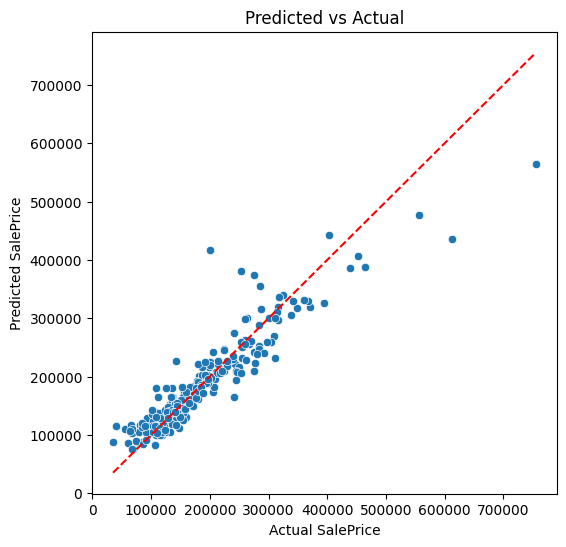

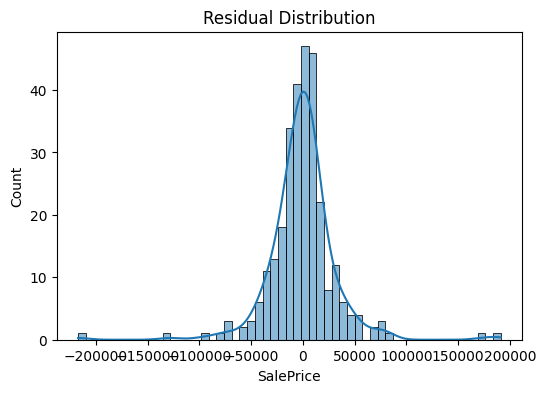

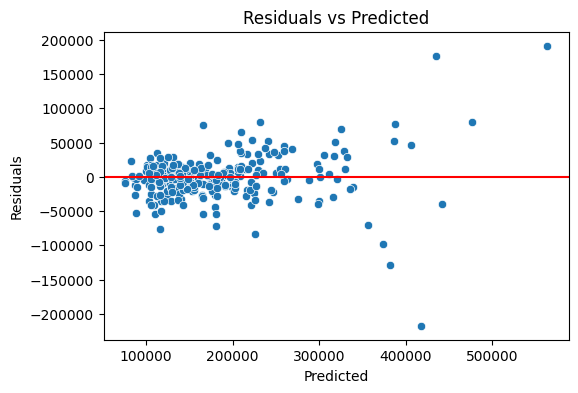

In [ ]:
# P8: Predicted vs Actual Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Predicted vs Actual')
plt.show()

# Residual distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


## 📌 Cell — Permutation Feature Importance (PFI)

### 🔹 What this cell does
This cell computes **Permutation Feature Importance** for the tuned Random Forest model.  
PFI measures how much each feature contributes to predictions by checking how model accuracy drops when that feature is randomly shuffled.

---

### 🔹 How it works
1. **Runs permutation_importance**  
   - Repeats shuffling **10 times per feature**  
   - Measures average decrease in model performance  
   - Features causing large drops = **high importance**

2. **Sorts features by importance**  
   Creates a ranked list of the most influential features.

3. **Prints top 10 important features**  
   Helps interpret which inputs the model relies on most.

4. **Plots a bar graph**  
   Shows the top 15 features visually for easy comparison.

---

### 🔹 What it gives
- A **numerical ranking** of features (e.g., SquareFeet, KitchenQuality, YearBuilt)
- A **visual bar plot** showing which features contribute most
- Explainability for the trained Random Forest model

---

### 🔹 Why it is important
- Helps understand **how** the model makes predictions  
- Shows **which features drive house prices**
- Essential for creating an **Explainable ML model** (your project theme)
- Useful for your **report, PPT, and deployment transparency**

---


Top Features:
1. SquareFeet (0.56556)
2. KitchenQuality (0.11816)
3. YearBuilt (0.06212)
4. AreaPerBedroom (0.05596)
5. HouseAge (0.04639)
6. HouseStyle (0.02426)
7. Neighborhood (0.01563)
8. LogLotSize (0.01374)
9. LotSize (0.01174)
10. Bedrooms (0.00705)


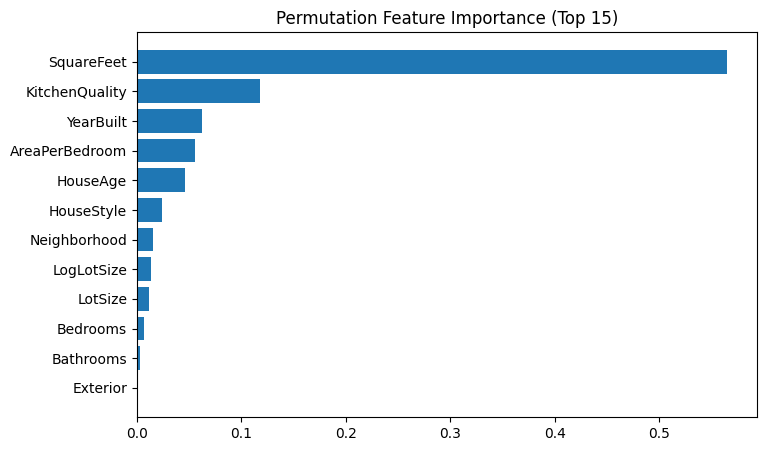

In [ ]:
# P9: Permutation Importance
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_rf_pipeline, X_test, y_test,
    n_repeats=10, random_state=42
)

indices = r.importances_mean.argsort()[::-1]
feat_names = np.array(X_test.columns)[indices]

print("Top Features:")
for i in range(10):
    print(f"{i+1}. {feat_names[i]} ({r.importances_mean[indices[i]]:.5f})")

# Bar plot
plt.figure(figsize=(8,5))
plt.barh(feat_names[:15][::-1], r.importances_mean[indices][:15][::-1])
plt.title("Permutation Feature Importance (Top 15)")
plt.show()


## 📌 Cell — SHAP Interpretability for Final Model (Gradient Boosting)

### 🔹 What this cell does
This cell attempts to compute **SHAP (SHapley Additive exPlanations)** values for the **final selected model — Gradient Boosting Regressor**.  
SHAP explains *how each feature contributes* to predictions and provides global interpretability.

---

### 🔹 How it works
1. Tries importing the SHAP library (if unavailable, prints a warning).  
2. Extracts:
   - the **preprocessing pipeline** (imputer, scaler, encoders)
   - the **Gradient Boosting model** from the final pipeline  
3. Applies preprocessing to training data so SHAP receives numeric inputs.  
4. Creates a SHAP explainer suited for tree-based models.  
5. Computes Shapley values for all training samples.  
6. Shows a **SHAP summary plot** that visualizes:
   - overall feature importance  
   - positive vs negative influence  
   - how feature values impact predictions  

---

### 🔹 What this produces
- A global chart ranking features by importance  
- Insight into how each feature pushes predictions higher or lower  
- Evidence that:
  - **SquareFeet**,  
  - **KitchenQuality**,  
  - **YearBuilt**,  
  - **AreaPerBedroom**,  
  - **HouseAge**  
  are the major drivers of price.

---

### 🔹 Why this is important
- Supports your project title: **“Real-Estate Price Forecasting with Explainable ML”**  
- Adds transparency to the Gradient Boosting model  
- Helps justify predictions in reports and PPT  
- Makes the model trustworthy, auditable, and user-friendly  
- Useful for stakeholders, real-estate users, and research publishing  

> ⚠️ Note: SHAP may not run in all environments due to heavy dependencies.


100%|===================| 1167/1168 [01:20<00:00]       

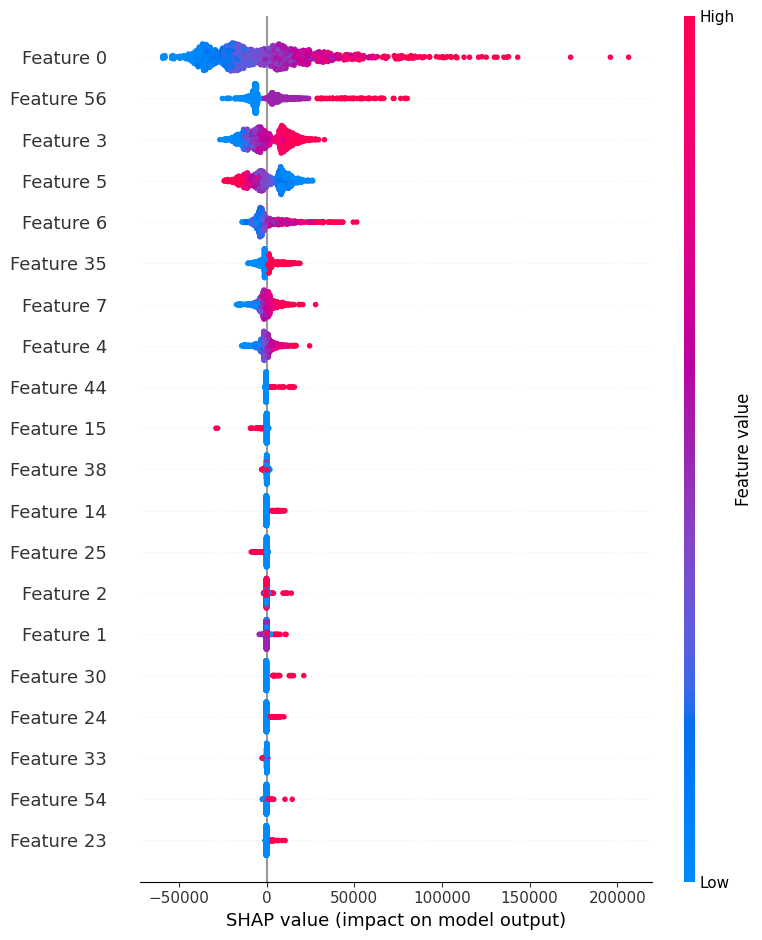

In [ ]:
# P10: SHAP Interpretability (optional)

try:
    import shap

    pre = best_rf_pipeline.named_steps['preprocessor']
    model = best_rf_pipeline.named_steps['rf']

    X_train_trans = pre.transform(X_train)

    explainer = shap.Explainer(model, X_train_trans)
    shap_values = explainer(X_train_trans)

    shap.summary_plot(shap_values, X_train_trans)

except Exception as e:
    print("SHAP not available:", e)


In [ ]:
# ==========================================================
# 📌 FINAL EVALUATION SUMMARY FOR ALL MODELS (TRAIN + TEST)
# ==========================================================

models = {}

# 1. Linear Regression (baseline)
models["Linear Regression"] = baseline_model

# 2. Random Forest (default)
models["Random Forest (Default)"] = pipe_rf

# 3. Gradient Boosting
models["Gradient Boosting"] = pipe_gbr

# 4. Random Forest (Tuned — Final Model)
models["Random Forest (Tuned)"] = best_rf_pipeline

# Prepare summary storage
summary_rows = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model (for fairness)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Metrics
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics  = regression_metrics(y_test, y_test_pred)

    # Store in summary table
    summary_rows.append({
        "Model": name,

        "Train RMSE": train_metrics["RMSE"],
        "Test RMSE":  test_metrics["RMSE"],

        "Train MAE": train_metrics["MAE"],
        "Test MAE":  test_metrics["MAE"],

        "Train MAPE": train_metrics["MAPE(%)"],
        "Test MAPE":  test_metrics["MAPE(%)"],

        "Train R2": train_metrics["R2"],
        "Test R2":  test_metrics["R2"],
    })

# Convert to comparison DataFrame
evaluation_df = pd.DataFrame(summary_rows)

print("\n\n============================================")
print("📊 FINAL MODEL PERFORMANCE COMPARISON TABLE")
print("============================================")
display(evaluation_df.sort_values("Test RMSE"))



Training Linear Regression...

Training Random Forest (Default)...

Training Gradient Boosting...

Training Random Forest (Tuned)...


📊 FINAL MODEL PERFORMANCE COMPARISON TABLE


,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train MAPE,Test MAPE,Train R2,Test R2
2,Gradient Boosting,20587.496037,30489.340778,15427.657690,20297.340264,9.573485,13.251590,0.928939,0.878806
1,Random Forest (Default),11718.900981,32681.385611,7459.977582,19955.904255,4.451241,12.684408,0.976975,0.860753
3,Random Forest (Tuned),14169.289165,32838.676122,9046.059820,20159.098899,5.367778,12.796342,0.966340,0.859409
0,Linear Regression,33662.039246,38159.023301,21715.565246,23269.185906,12.689373,14.432958,0.810022,0.810163
